# Chronos-t5 を試す

Amazon が最近公開した Chronos-t5 を試してみます。
Chronos-t5 は、言語モデルのアーキテクチャーを用いた事前学習済みの時系列モデルです。

特徴:

- 言語モデルのアーキテクチャーを用いた事前学習済みの時系列モデル
- 時系列データをトークン列に変換し、言語モデルで学習させる
- 710M パラメーターの Chronos-t5-large モデルを使って、時系列データの予測を行います。

Huggingface 上の説明文の翻訳:

`Chronosは、言語モデルアーキテクチャに基づいた時系列予測のための事前学習済みモデルファミリーです。時系列データはスケーリングと量子化によってトークン列に変換され、言語モデルはクロスエントロピー損失を用いてこれらのトークンで学習されます。学習後、確率的な予測は、過去のコンテキストを与えて複数の未来の軌跡をサンプリングすることで得られます。Chronosモデルは、公開されている大規模な時系列データと、ガウス過程を用いて生成された合成データを用いて学習されています。`

- モデル: https://huggingface.co/amazon/chronos-t5-large
- 論文: https://arxiv.org/abs/2403.07815


## セットアップ


In [ ]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git
!pip install pandas matplotlib torch

## AirPassengers のデータセットで試す

時系列系データセットでよく用いられる AirPassengers のデータセットを使って、Chronos-t5 で予測を行います。
サンプルコードを少し変えてどのくらいの精度で予測ができるのか見てみましょう。


In [2]:
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = [12, 6]

df = pd.read_csv(
    "https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv"
)

df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


<Axes: xlabel='Month'>

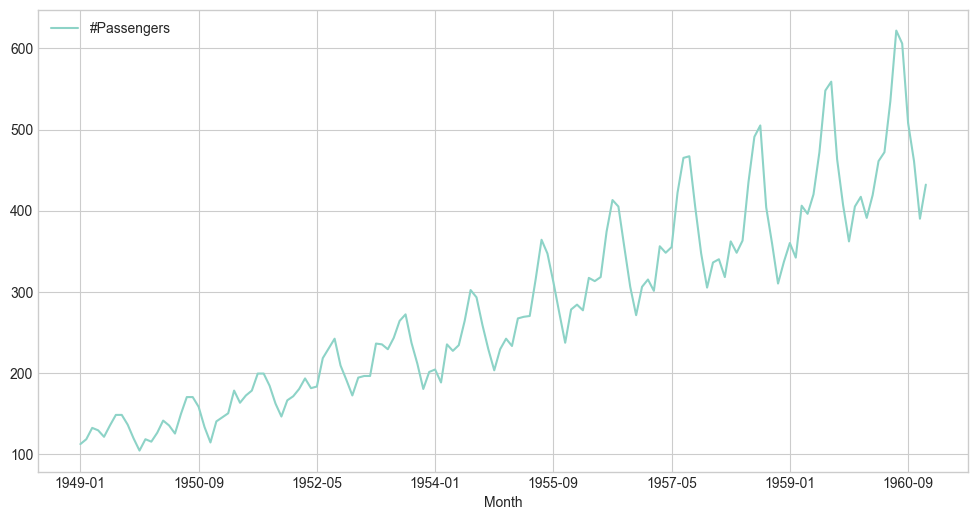

In [3]:
# データセットの目視確認
df.set_index("Month").plot()

こんな感じの季節性とトレンドのある小さなデータセットです。


## Chronos を使って予測


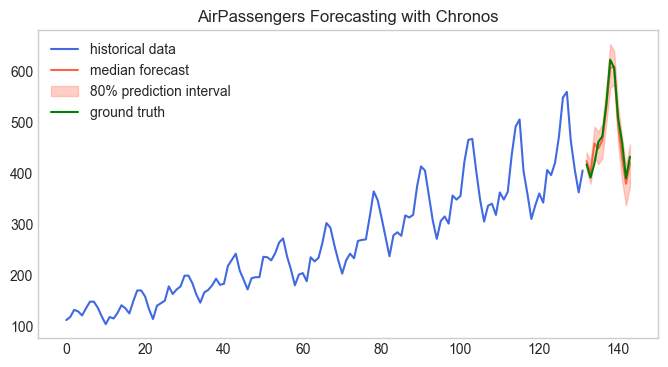

In [4]:
import numpy as np
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="auto",
)

prediction_length = 12
train = df["#Passengers"].values[:-prediction_length]
val = df["#Passengers"].values[-prediction_length:]

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(train)

forecast = pipeline.predict(
    context,
    prediction_length,
    num_samples=100,
)  # shape [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(train), len(train) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(train, color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(
    forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval"
)
plt.plot(range(len(train), len(train) + len(val)), val, color="green", label="ground truth")
plt.legend()
plt.title("AirPassengers Forecasting with Chronos")
plt.grid()
plt.show()

無事予測ができました。かなり精度が高いように見えます。


In [16]:
forecast.shape

torch.Size([1, 100, 12])

In [6]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
)

mae = mean_absolute_error(val, median)
rmse = root_mean_squared_error(val, median)
mape = mean_absolute_percentage_error(val, median)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape*100:.2f}%")

MAE: 13.75
RMSE: 17.02
MAPE: 3.02%


## 終わりに

Chronos-t5 を使って時系列データの予測を行いました。
時系列モデルのトークナイズと、事前学習済みのモデルを使うことで、時系列データの予測ができることがわかりました。

今回共有できない独自データセットでも試したのですが、他の時系列モデルと比べても実用性が出る場面がありそうでした。
是非とも実践の場でも活用していきたいです。

以上、お読みいただきありがとうございます。少しでも参考になればと思います。

もし似たようなコンテンツに興味があれば、フォローしていただけると嬉しいです：

- [note](https://note.com/alexweberk/) と
- [Twitter](https://twitter.com/alexweberk)

https://twitter.com/alexweberk

今回使った Notebook の Gist: https://gist.github.com/alexweberk/2ed7f5b262bb9acead8f547aa8ce86e6
